In [1]:
# Data Processing
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import seaborn as sns   # plotting heatmap
import matplotlib.pyplot as plt
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

from scipy.stats import randint, uniform
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

2024-11-08 12:35:59.797555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 12:35:59.830794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 12:35:59.840846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 12:35:59.864956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 12:36:01.633839: W tensorflow/compiler/tf2

In [2]:
def metrics_function(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    TPR = TP / (TP + FN) # Recall
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    NPV = TN / (TN + FN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    ACCURACY = (TP + TN) / (TP + FP + FN + TN)
    PRECISION = TP / (TP + FP)
    ERROR_RATE = (FP + FN) / (TP + FP + FN + TN)
    F1 = (2 * TP) / (2 * TP + FP + FN)
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, PRECISION, F1, ACCURACY, ERROR_RATE, BACC, TSS, HSS]


In [3]:
# Get data features and labels
# Split the data into features (X) and target (y)

sentiment_data = pd.read_csv(f'{os.getcwd()}/dataset/review_sentiment_labelled.csv')
X = sentiment_data["Sentence"]
y = sentiment_data['Score']
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.3)

vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)


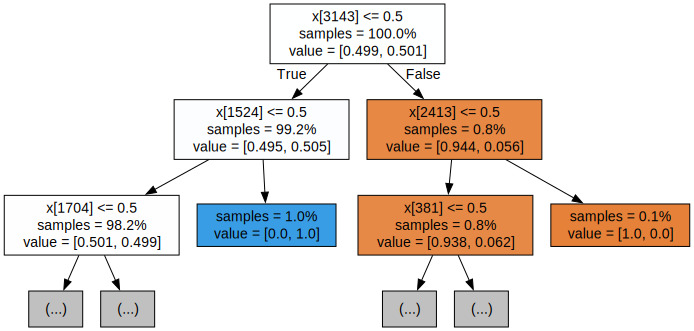

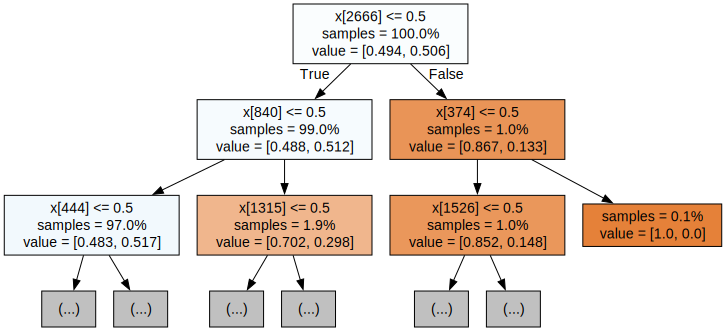

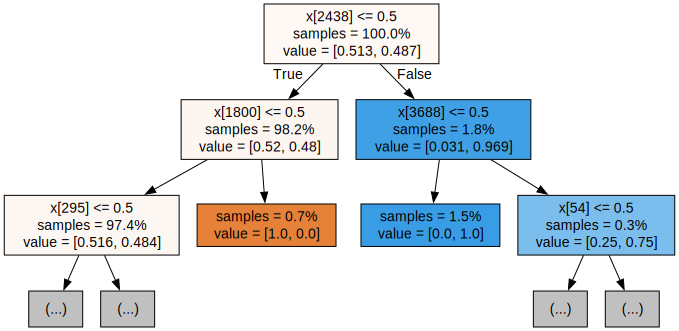

Best hyperparameters: {'max_depth': 17, 'n_estimators': 228}


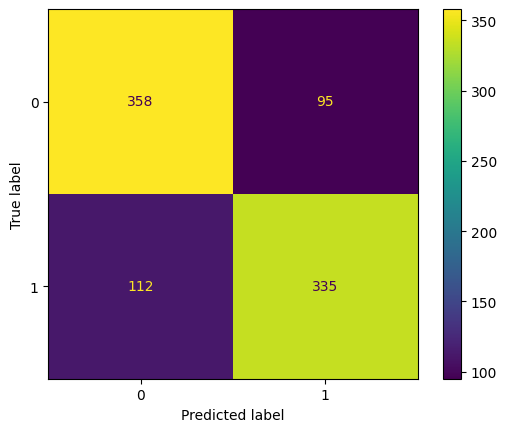

In [4]:
# Random Forrest Implementation
rf = RandomForestClassifier()
rf.fit(vector_sentiment_train, train_score)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=10)

# Fit the random search object to the data
rand_search.fit(vector_sentiment_train, train_score)
# # Create a variable for the best model
best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Confusion Matrix setup, prediction with the best models
predicted_score_best = best_rf.predict(vector_sentiment_test)
cm = confusion_matrix(test_score, predicted_score_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Best Hyperparameters:  {'C': 3.3185581342948365, 'gamma': 0.005428675439323859, 'kernel': 'linear'}


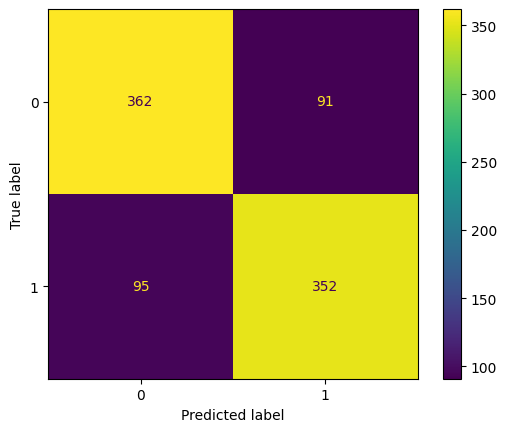

In [5]:
# Support Vector Machine Implementation
svm = SVC()
param_dist = {
    'C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 50))
}
randomized_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=10, cv=10)

randomized_search.fit(vector_sentiment_train, train_score)

print("Best Hyperparameters: ", randomized_search.best_params_)
best_svm = randomized_search.best_estimator_

predicted_score_best_svm = best_svm.predict(vector_sentiment_test)
cm_svm = confusion_matrix(test_score, predicted_score_best_svm)

ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot();

# # Scatter plot
# plt.scatter(X[:, 0], X[:, 1], 
#             c=y, 
#             s=20, edgecolors="k")
# plt.show()



int64


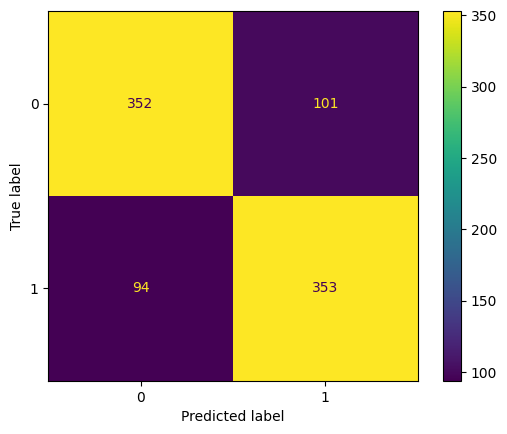

In [37]:
# RNN Bidirectional LSTM Implementation 
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(np.array(train_sentiment))
rnn = tf.keras.Sequential([encoder,
                           tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                     output_dim=64,
        # Use masking to handle the variable sequence lengths
                                                     mask_zero=True),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)])

rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
	# fit model
rnn.fit(np.array(train_sentiment), np.array(train_score), epochs=10, batch_size=64, verbose=0)

predicted_score = rnn.predict(test_sentiment, verbose=0)
# print(predicted_score)
predicted_score_class = (tf.sigmoid(predicted_score) > 0.5).numpy().astype("int64")
cm_rnn = confusion_matrix(test_score, predicted_score_class)
ConfusionMatrixDisplay(confusion_matrix=cm_rnn).plot();

In [41]:
rf_evaluate = []
svm_evaluate = []
rnn_evaluate = []
metric_des = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 
              'TSS', 'HSS']
# Implement KFold cross validation (To be continued) Also remember to add the Brier score, ROC, 
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
iter = 0
for tr_index, ts_index in k_fold.split(X):
    iter += 1
    print(f'Iteration {iter}')
    train_sentiment, test_sentiment = X[tr_index], X[ts_index]
    train_score, test_score = y[tr_index], y[ts_index]
    rf_model_iter = RandomForestClassifier(max_depth=best_rf.max_depth, n_estimators=best_rf.n_estimators) # Initialize RF with best params
    svm_model_iter = SVC(C=best_svm.C, gamma=best_svm.gamma, kernel=best_svm.kernel) # Initialize SVM with best params
    VOCAB_SIZE = 1000
    encoder_iter = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
    encoder_iter.adapt(np.array(train_sentiment))
    rnn_model_iter = tf.keras.Sequential([encoder_iter, tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                     output_dim=64,
                                                     mask_zero=True),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)])
    rnn_model_iter.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    vectorizer_inx = CountVectorizer()
    vector_sentiment_train_inx = vectorizer_inx.fit_transform(train_sentiment)
    vector_sentiment_test_inx = vectorizer_inx.transform(test_sentiment)
     # Fit models with training data and label for each iteration
    rf_model_iter.fit(vector_sentiment_train_inx, train_score)
    svm_model_iter.fit(vector_sentiment_train_inx, train_score)
    rnn_model_iter.fit(np.array(train_sentiment), np.array(train_score), epochs=10, batch_size=64, verbose=0)
    # Get the Predicted value for the models for each iteration
    predicted_rf_inx = rf_model_iter.predict(vector_sentiment_test_inx)
    predicted_svm_inx = svm_model_iter.predict(vector_sentiment_test_inx)
    predicted_rnn = rnn_model_iter.predict(test_sentiment, verbose=0)
    predicted_rnn_inx = (tf.sigmoid(predicted_rnn) > 0.5).numpy().astype("int64")
    # Get the confusion matrix for the models for each iteration
    cm_rf_inx = confusion_matrix(test_score, predicted_rf_inx)
    cm_svm_inx = confusion_matrix(test_score, predicted_svm_inx)
    cm_rnn_inx = confusion_matrix(test_score, predicted_rnn_inx)
    rf_metric_inx = metrics_function(cm_rf_inx)
    svm_metric_inx = metrics_function(cm_svm_inx)
    rnn_metric_inx = metrics_function(cm_rnn_inx)
    rf_evaluate.append(rf_metric_inx)
    svm_evaluate.append(svm_metric_inx)
    rnn_evaluate.append(rnn_metric_inx)
    evaluated_metrics = pd.DataFrame([rf_metric_inx, svm_metric_inx, rnn_metric_inx], columns=metric_des, index=['RF', 'SVM', 'RNN'])
    print(evaluated_metrics.round(2).T)
    

Iteration 1
                RF     SVM     RNN
TP          120.00  107.00  108.00
TN          117.00  132.00  140.00
FP           47.00   32.00   24.00
FN           16.00   29.00   28.00
TPR           0.88    0.79    0.79
TNR           0.71    0.80    0.85
FPR           0.29    0.20    0.15
FNR           0.12    0.21    0.21
Precision     0.72    0.77    0.82
F1_measure    0.79    0.78    0.81
Accuracy      0.79    0.80    0.83
Error_rate    0.21    0.20    0.17
BACC          0.80    0.80    0.82
TSS           0.60    0.59    0.65
HSS           0.58    0.59    0.65
Iteration 2
                RF     SVM     RNN
TP          130.00  136.00  130.00
TN          113.00  116.00  123.00
FP           24.00   21.00   14.00
FN           33.00   27.00   33.00
TPR           0.80    0.83    0.80
TNR           0.82    0.85    0.90
FPR           0.18    0.15    0.10
FNR           0.20    0.17    0.20
Precision     0.84    0.87    0.90
F1_measure    0.82    0.85    0.85
Accuracy      0.81    0.84    0